# Model 2
## Logistic regression with Tensorflow

# Libraries

In [7]:
import glob
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt

# Read Images Function

In [39]:
def ReadImages(path, get_labels=True):
	'''
	This functions read all images from a folder (using PIL library) and return them as a numpy array.
	All images are resized to 32x32 pixels, in accordance with the LeNet 5 structure.

	@path: Path where the images are store
	@get_labels: Ween set to True, the function will try to get the label from the image name (the digits after the last _ chatacter). 

	return a numpy array for the images and another one for the labels (in case it is necessary)
	'''
    
	#Complete the path in case is incomplete
	if path[-1] != '/':
		path += '/'

	#Read images from folder        
	images_paths = glob.glob(path+'*.ppm')
	print(len(images_paths), "images found on folder")

	#Initialize lists    
	images = []
	labels = []

	#Loop around all images on the folder  
	print("Reading images...")    
	cont = 0
	for image_path in images_paths:
		#Open image with PIL        
		image = Image.open(image_path)
		#Resize Image        
		image = image.resize((32,32))
		#Convert image to array and normilize.
		#Append the image to the images list        
		images.append(np.array(image.getdata()).reshape(-1)/255)

		#If get_labels is set to True, get the image label        
		if get_labels:
			pos1 = image_path.rfind('_')+1 #Find the position of the last _ character
			pos2 = image_path.find('.', pos1) #Find the position of the . character
			labels.append(int(image_path[pos1:pos2])) #Get the label and append it to the labels list

		cont += 1 #Increase counter
		#If the counter is a multiple of 1000, print        
		if cont%10000 == 0:
			print(cont, "/", len(images_paths))
		#elif cont>10000 == 0:
			#break

	#Convert images list to numpy array            
	images = np.asarray(images)
	labels = np.asarray(labels)

	#If get_labels is set to True, return images and labels, otherwise returns just images    
	if get_labels:
		return images, labels
	else:
		return images		


**Example:**

In [5]:
ReadImages('../images/train')

66232 images found on folder
Reading images...
10000 / 66232
20000 / 66232
30000 / 66232
40000 / 66232
50000 / 66232
60000 / 66232


(array([[0.1372549 , 0.18039216, 0.25490196, ..., 0.09019608, 0.11372549,
         0.14901961],
        [0.13333333, 0.12941176, 0.12941176, ..., 0.11372549, 0.10588235,
         0.10588235],
        [0.10196078, 0.09019608, 0.09803922, ..., 0.2627451 , 0.32156863,
         0.34117647],
        ...,
        [0.04313725, 0.04313725, 0.05490196, ..., 0.05098039, 0.05098039,
         0.0627451 ],
        [0.84705882, 0.85098039, 0.88235294, ..., 0.60392157, 0.65490196,
         0.68235294],
        [0.09803922, 0.08235294, 0.08627451, ..., 0.08235294, 0.07843137,
         0.09411765]]), array([12, 31, 12, ..., 38, 13, 31]))

# ANN Class Definition

In [36]:
class ANN(object):
	"""
	This class represents a Neural Network. It will be used as a logistic regression but only adding one neuron.
	It allows to initalize the structure of the network as well as predict and train
	Methods:
		__init__: Initialize the structure of the logistic regression
		fit: Perform the training process over the network
		predict: Predict the classes of images
		score: Calculate the accuracy over a test of images
		forward: Perform the forward propagation stage of the network
	"""
	def __init__(self, D, K):
		'''
		Initialize the structure of the logistic regression
		@D: Number of dimensions of an image. It will be 3072 (32*32*3)
		@K: Number of output classes. It will be 43
		'''

		#Initialize the place holders for inputs and labels.
		self.inputs = tf.placeholder(tf.float32, shape = (None, D), name='inputs')
		self.labels = tf.placeholder(tf.int64, shape = (None, ), name='labels')

		#Initilize the weight and bias variables for the only neuron
		self.W = tf.Variable((np.random.randn(D, K) * np.sqrt(2.0 / D)).astype(np.float32))
		self.b = tf.Variable((np.zeros(K)).astype(np.float32))

		#The logit are defined as the forward steo of one neuron.
		#It doesn't have the softmax function as it is included on the cost function.
		self.logits = tf.matmul(self.inputs, self.W)+self.b

		#The prediction is obtained after applying softmax and argmax to the logits
		self.prediction = tf.argmax(tf.nn.softmax(self.logits),1)

		#The cost function uses the cross entropy function. It already includes the softmax operation over the logits
		self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.labels))

	def fit(self, X, Y):
		'''
		This function performs the training process of the logistic regression
		@X: Training images
		@Y: Training labels
		'''

		N, D = X.shape #Size of the image array
		K = len(set(Y)) #Number of output classes

		lr = 1e-4 #Learning rate
		decay = 0.9 #Decay
		mu = 0.9 #Momentum

		#Optimizer that will minimize the cost function
		train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(self.cost)

		#TRAINING PROCESS
		init = tf.global_variables_initializer() #Initialize tensorflow variables
		saver = tf.train.Saver(max_to_keep=1) #Initialize tensorflow saver
		batch_sz = 500 #Define batch size
		iteration = 0 #Initialize iteration
		max_iterations = 5000 #Define a maximum number of iterations

		#Start tensorflow session
		#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session: #With GPU
		with tf.Session() as session:	#No GPU

			session.run(init) #Run initialization

			#Loop around all iterations
			while iteration < max_iterations:
				
				X, Y = shuffle(X, Y) #Shuffle the images and its labels


				for e in range(0, N, batch_sz): #Epoch loop

					iteration += 1 #Increase iteration

					#Select the X and Y values for the current batch
					Xbatch = X[e:e+batch_sz]
					Ybatch = Y[e:e+batch_sz]

					#Perform the train operation
					session.run(train_op, feed_dict={self.inputs:Xbatch, self.labels:Ybatch})

					#Every 20 iterations, print and save
					if iteration%200 == 0:

						#Get the cost and accuracy for current batch 
						c, p = session.run((self.cost, self.prediction), feed_dict={self.inputs:Xbatch, self.labels:Ybatch})
						acc = accuracy_score(Ybatch, p)

						#Print the costs and accuracies for both tests
						print(iteration, "Cost:", c, "Accuracy:", acc)

						#Save the tensorflow model
						saver.save(session, '../models/model2/saved/model2') 

			#Save the tensorflow model
			saver.save(session, '../models/model2/saved/model2')			
	
	def predict(self, X):
		'''
		This functions predic the classes form a set of images X
		@X: Images in a numpy array 

		returns a numpy array of size (Nx1) with the class of each image
		'''

		#Initialize tensorflow variables and saver
		init = tf.global_variables_initializer()
		saver = tf.train.Saver()

		#Initialize Tensorflow session
		#with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session: #GPU
		with tf.Session() as session:	#CPU-only
			#Load tensorflow model
			load_file = '../models/model2/saved/model2'
			saver.restore(session, load_file)

			#Predict the classes
			pred = session.run(self.prediction, feed_dict={self.inputs:X})

		return pred	

	def score(self, X, Y):
		'''
		Evaluate the accuracy of the prediction over a set of images
		@X: Images in a 4D numpy array 
		@Y: Images classes in a 1D numpy array 
		'''
		pred = self.predict(X) #Predict the classes of the images

		#Get the accuracy of the prediction
		return accuracy_score(Y, pred)				


# Model Function

In [42]:
def model2(c_type, image_path):
	'''
	This model identify what operation is going to be perform with the model2 (train, test or infer) and call the a function in accordance.
	@c_type: Operation type. It could be train, test or infer
	@image_path: Path to the images folder
	'''

	model_path = 'models/model2/saved/model2' #Path where the model is saved
	if c_type == 'train':
		#Call ReadImages function
		X, Y = ReadImages(image_path)
		Xtest, Ytest = ReadImages('images/test/')

		#Get the size of the images array
		N, D = X.shape
		#Get the number of output classes
		K = len(set(Y))

		#Initialize object of type ANN (logistic regression)
		NN = ANN(D, K)
		
		#Perform training
		NN.fit(X, Y, Xtest, Ytest)

	elif c_type == 'test':
		#Call ReadImages function
		X, Y = ReadImages(image_path)

		#Get the size of the images array 
		N, D = X.shape
		#Get the number of output classes
		K = len(set(Y))

		#Initialize object of type ANN (logistic regression)	
		tf.reset_default_graph()
		NN = ANN(D, K)
		
		#Print accuracy of the test
		print("Accuracy:", NN.score(X, Y))

	elif c_type == 'infer':
		#Call ReadImages function, with get_labels attribute set as False
		images_paths = ReadImages(image_path, False)

		#Get the size of the images array 
		N, D = images_paths.shape
		#Define the number of output classes
		K = 43

		#Initialize object of type ANN (logistic regression)
		tf.reset_default_graph()        
		NN = ANN(D, K)

		#Predict labels
		results = NN.predict(images_paths)

		for i in range(0, len(images_paths)): #Loop around all images
			#Get i image and label
			image = images_paths[i]
			result = results[i]

			#Set titile of the image as the class
			plt.title("Class "+str(result))
			#Delete axis
			plt.axis('off')

			#Show image
			plt.imshow(image.reshape(32,32,-1))
			plt.show()

			#As the user if he/she wants to continue with the next image
			inputted = input("Next Image? (y/n)")
			if inputted.lower() != 'y':
				break

# Examples:

## Test

In [40]:
model2('test', '../images/test/')

16775 images found on folder
Reading images...
10000 / 16775
INFO:tensorflow:Restoring parameters from ../models/model2/saved/model2
Accuracy: 0.9787183308494783


## Infer

16775 images found on folder
Reading images...
10000 / 16775
INFO:tensorflow:Restoring parameters from ../models/model2/saved/model2


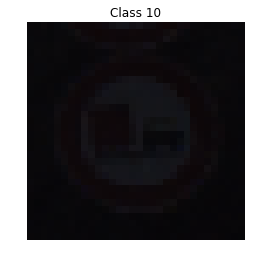

Next Image? (y/n)y


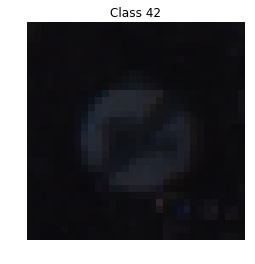

Next Image? (y/n)y


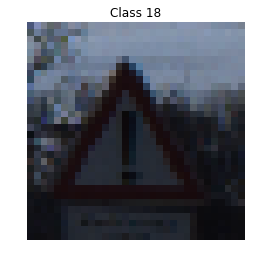

Next Image? (y/n)y


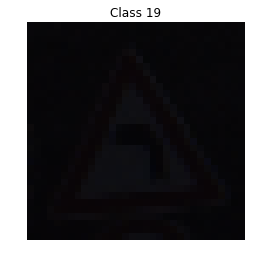

Next Image? (y/n)y


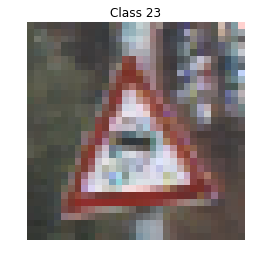

Next Image? (y/n)n


In [43]:
model2('infer', '../images/test/')